In [ ]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import warnings

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression


def warn(*args, **kwargs):
    pass


warnings.warn = warn
warnings.filterwarnings('ignore')

In [45]:
df =  pd.read_csv("Housing.csv")
df.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   price             545 non-null    int64 
 1   area              545 non-null    int64 
 2   bedrooms          545 non-null    int64 
 3   bathrooms         545 non-null    int64 
 4   stories           545 non-null    int64 
 5   mainroad          545 non-null    object
 6   guestroom         545 non-null    object
 7   basement          545 non-null    object
 8   hotwaterheating   545 non-null    object
 9   airconditioning   545 non-null    object
 10  parking           545 non-null    int64 
 11  prefarea          545 non-null    object
 12  furnishingstatus  545 non-null    object
dtypes: int64(6), object(7)
memory usage: 55.5+ KB


The dataset contains 545 records for each column, with no missing values

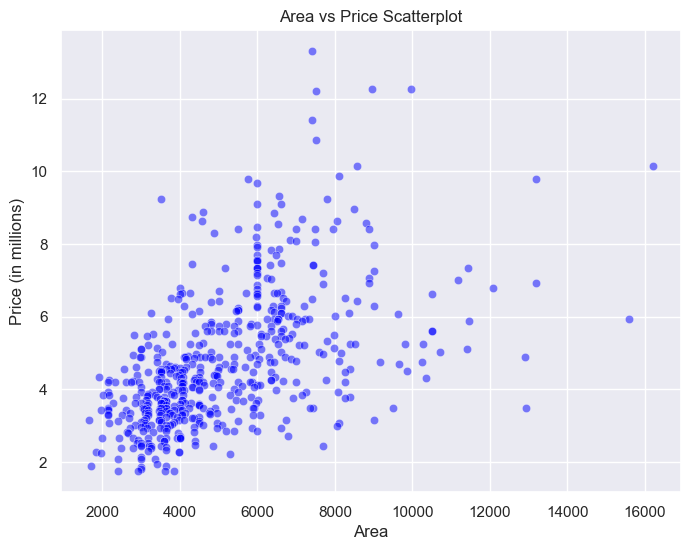

In [16]:
plt.figure(figsize=(8,6))
sns.scatterplot(x=df['area'], y=df['price']/1000000, alpha=0.5, color='blue')
plt.xlabel('Area')
plt.ylabel('Price (in millions)')
plt.title('Area vs Price Scatterplot')
plt.show()

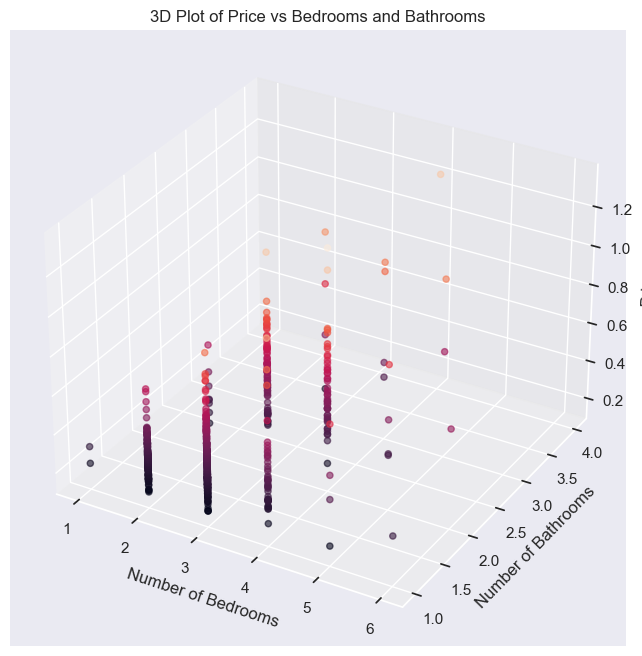

In [41]:
# Create a 3D figure
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot data
ax.scatter(df['bedrooms'], df['bathrooms'], df['price'], c=df['price'], marker='o', alpha=0.6)

# Label axes
ax.set_xlabel('Number of Bedrooms')
ax.set_ylabel('Number of Bathrooms')
ax.set_zlabel('Price')
ax.set_title('3D Plot of Price vs Bedrooms and Bathrooms')

# Show plot
plt.show()

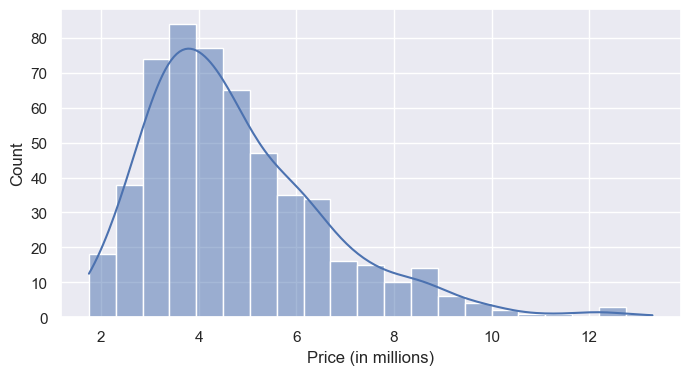

In [17]:
ax = sns.histplot(df['price']/1000000, kde=True)
plt.xlabel('Price (in millions)')
plt.show()

In [10]:
df[df['price']>=12000000].count()

price               4
area                4
bedrooms            4
bathrooms           4
stories             4
mainroad            4
guestroom           4
basement            4
hotwaterheating     4
airconditioning     4
parking             4
prefarea            4
furnishingstatus    4
dtype: int64

This distribution looks like a log-normal distribution. Instead of using the house sale price as the outcome/target, I use the log(price)

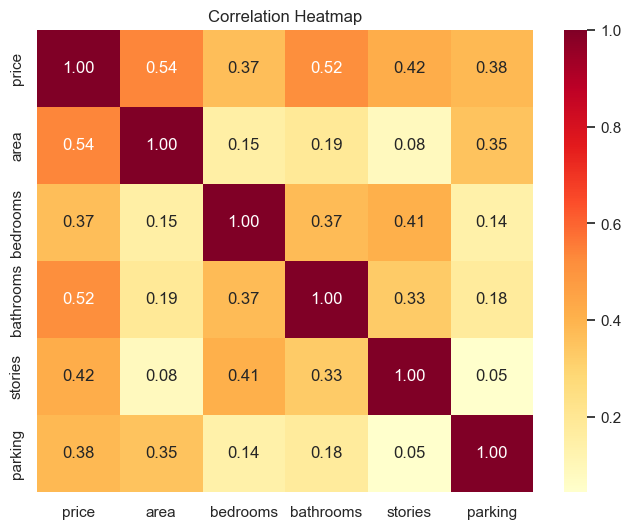

In [17]:
plt.figure(figsize=(8,6))
sns.heatmap(df.corr(), annot=True, fmt=".2f",cmap='YlOrRd')
plt.title('Correlation Heatmap')
plt.show()

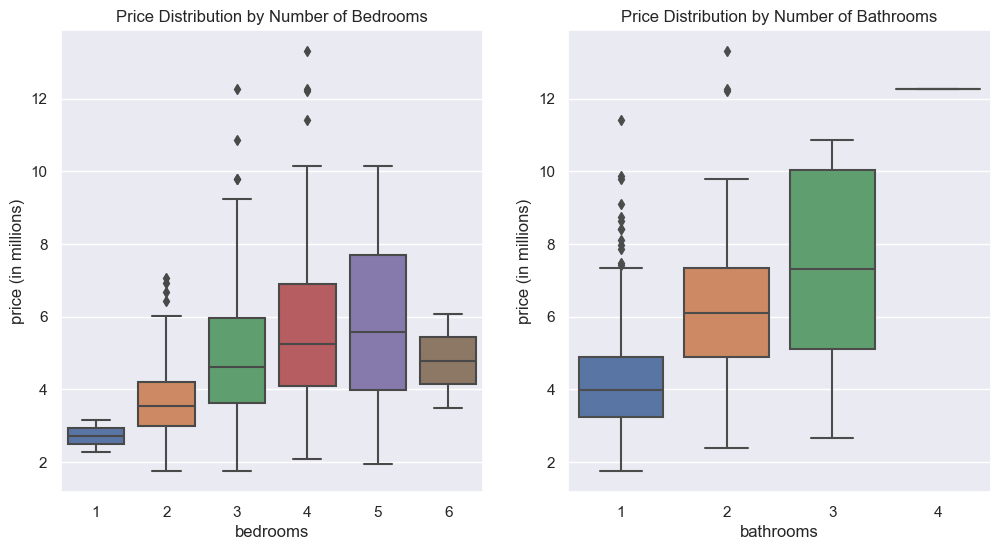

In [12]:
fig = plt.figure(figsize=(12,6))

ax = fig.add_subplot(1, 2, 1)
sns.boxplot(x='bedrooms', y=df['price']/1000000, data=df)
plt.title('Price Distribution by Number of Bedrooms')
plt.ylabel('price (in millions)')

ax = fig.add_subplot(1, 2, 2)
sns.boxplot(x='bathrooms', y=df['price']/1000000, data=df)
plt.title('Price Distribution by Number of Bathrooms')
plt.ylabel('price (in millions)')
plt.show()

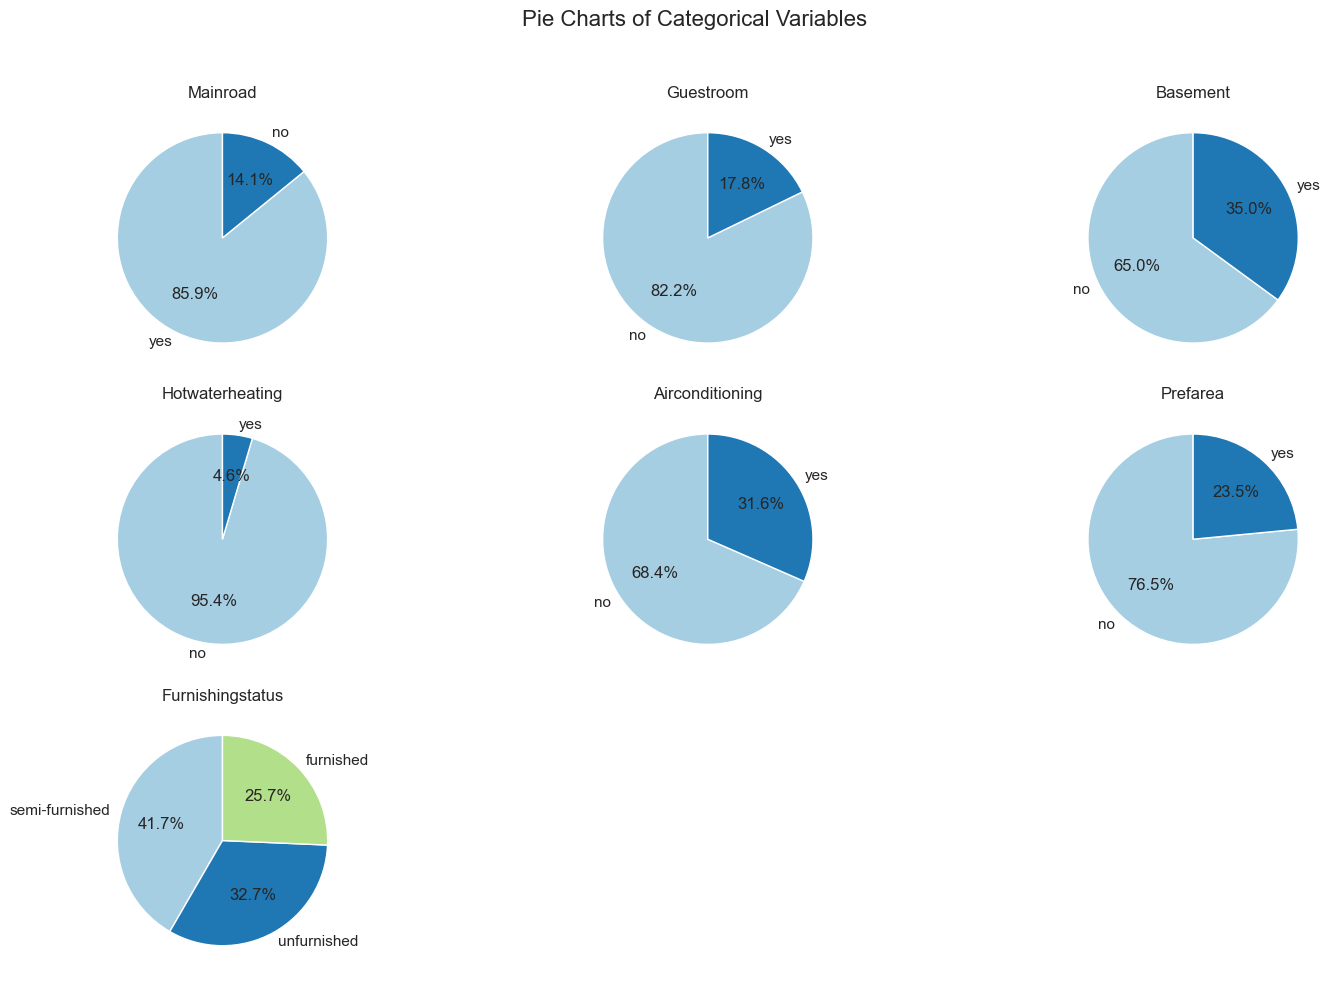

In [62]:
import matplotlib.pyplot as plt

# List of categorical variables
categorical_vars = ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea', 'furnishingstatus']

# Define the number of subplots based on the number of categorical variables
n_vars = len(categorical_vars)
n_cols = 3  # Number of columns for subplots
n_rows = (n_vars // n_cols) + (n_vars % n_cols > 0)  # Calculate rows needed

# Create the figure and axes for subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 10))
fig.suptitle('Pie Charts of Categorical Variables', fontsize=16)

# Loop through each categorical variable and create a pie chart
for i, var in enumerate(categorical_vars):
    row = i // n_cols
    col = i % n_cols
    ax = axes[row, col]
    
    # Get the counts of each category in the variable
    counts = df[var].value_counts()
    
    # Plot pie chart
    ax.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=90, colors=plt.cm.Paired.colors)
    ax.set_title(f'{var.capitalize()}')
    
# If there are empty subplots, remove them
for j in range(i + 1, n_rows * n_cols):
    fig.delaxes(axes[j // n_cols, j % n_cols])

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [64]:
pd.options.display.float_format = '{:.2f}'.format
df.describe()

,price,area,bedrooms,bathrooms,stories,parking
count,545.00,545.00,545.00,545.00,545.00,545.00
mean,4766729.25,5150.54,2.97,1.29,1.81,0.69
std,1870439.62,2170.14,0.74,0.50,0.87,0.86
min,1750000.00,1650.00,1.00,1.00,1.00,0.00
25%,3430000.00,3600.00,2.00,1.00,1.00,0.00
50%,4340000.00,4600.00,3.00,1.00,2.00,0.00
75%,5740000.00,6360.00,3.00,2.00,2.00,1.00
max,13300000.00,16200.00,6.00,4.00,4.00,3.00


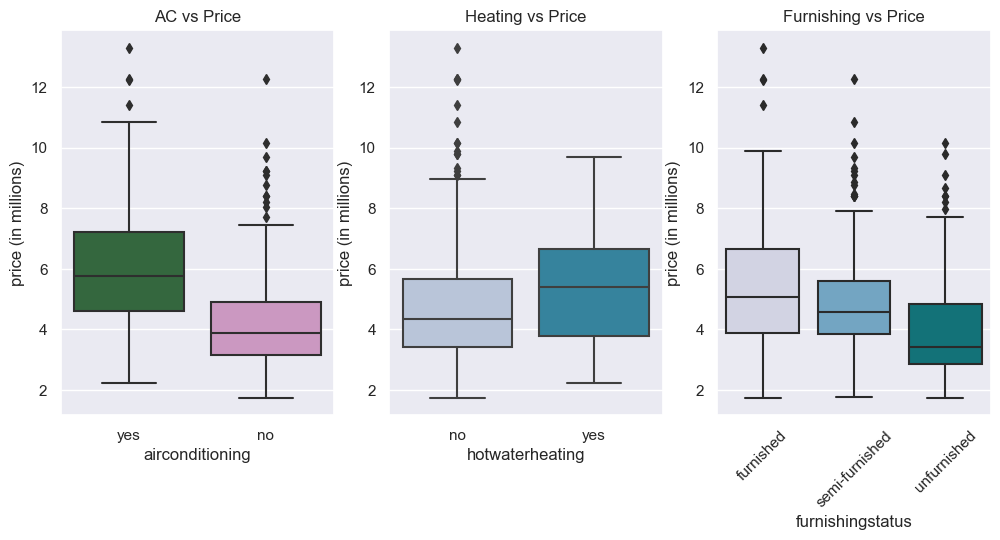

In [19]:
plt.figure(figsize=(12,5))

plt.subplot(1,3,1)
plt.title('AC vs Price')
sns.boxplot(x=df.airconditioning, y=df['price']/1000000, palette=("cubehelix"))
plt.ylabel('price (in millions)')

plt.subplot(1,3,2)
plt.title('Heating vs Price')
sns.boxplot(x=df.hotwaterheating, y=df['price']/1000000, palette=("PuBuGn"))
plt.ylabel('price (in millions)')

plt.subplot(1,3,3)
plt.title('Furnishing vs Price')
sns.boxplot(x=df.furnishingstatus, y=df['price']/1000000, palette=("PuBuGn"))
plt.xticks(rotation=45)
plt.ylabel('price (in millions)')

plt.show()



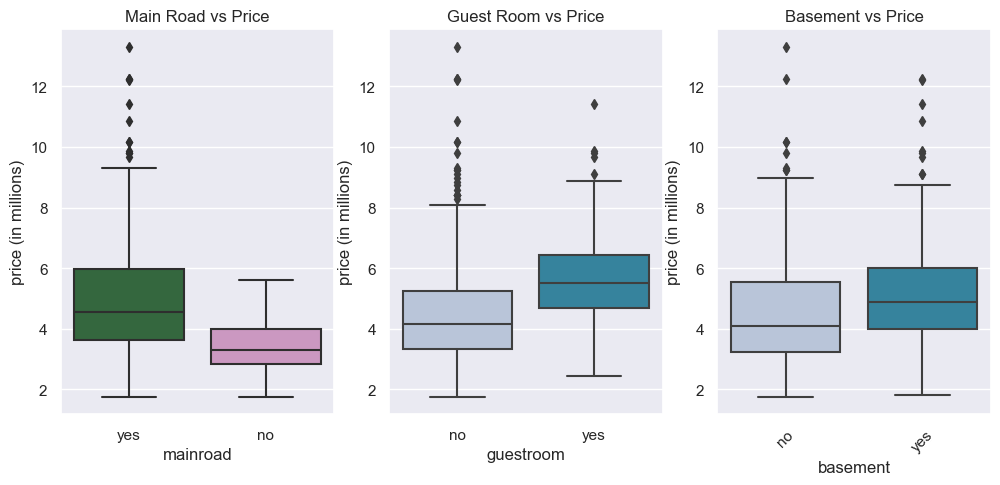

In [21]:
plt.figure(figsize=(12,5))

plt.subplot(1,3,1)
plt.title('Main Road vs Price')
sns.boxplot(x=df.mainroad, y=df['price']/1000000, palette=("cubehelix"))
plt.ylabel('price (in millions)')

plt.subplot(1,3,2)
plt.title('Guest Room vs Price')
sns.boxplot(x=df.guestroom, y=df['price']/1000000, palette=("PuBuGn"))
plt.ylabel('price (in millions)')

plt.subplot(1,3,3)
plt.title('Basement vs Price')
sns.boxplot(x=df.basement, y=df['price']/1000000, palette=("PuBuGn"))
plt.ylabel('price (in millions)')
plt.xticks(rotation=45)

plt.show()

### DATA PREPARATION 

In [22]:
df.dtypes

price                int64
area                 int64
bedrooms             int64
bathrooms            int64
stories              int64
mainroad            object
guestroom           object
basement            object
hotwaterheating     object
airconditioning     object
parking              int64
prefarea            object
furnishingstatus    object
dtype: object

In [25]:
df.mainroad.value_counts()

yes    468
no      77
Name: mainroad, dtype: int64

In [48]:
df2 = df

In [49]:
for col in df2.select_dtypes('object').columns:
    if col != 'furnishingstatus':
        df2[col] = df2[col].map({'yes':1, 'no':0})

In [50]:
df2.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,1,0,0,0,1,2,1,furnished
1,12250000,8960,4,4,4,1,0,0,0,1,3,0,furnished
2,12250000,9960,3,2,2,1,0,1,0,0,2,1,semi-furnished
3,12215000,7500,4,2,2,1,0,1,0,1,3,1,furnished
4,11410000,7420,4,1,2,1,1,1,0,1,2,0,furnished


In [51]:
df2['furnishingstatus'] = df2['furnishingstatus'].map({'furnished':0, 'semi-furnished':1,'unfurnished':0})

In [52]:
df2.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,1,0,0,0,1,2,1,0
1,12250000,8960,4,4,4,1,0,0,0,1,3,0,0
2,12250000,9960,3,2,2,1,0,1,0,0,2,1,1
3,12215000,7500,4,2,2,1,0,1,0,1,3,1,0
4,11410000,7420,4,1,2,1,1,1,0,1,2,0,0


In [56]:
# Drop the 'price' column from df2 before standardizing
scaler = StandardScaler()
df_standardized = scaler.fit_transform(df2.drop(columns=['price']))
df_standardized = pd.DataFrame(df_standardized, columns=df2.drop(columns=['price']).columns)

df_standardized


,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,1.046726,1.403419,1.421812,1.378217,0.405623,-0.465315,-0.734539,-0.219265,1.472618,1.517692,1.804941,-0.844888
1,1.757010,1.403419,5.405809,2.532024,0.405623,-0.465315,-0.734539,-0.219265,1.472618,2.679409,-0.554035,-0.844888
2,2.218232,0.047278,1.421812,0.224410,0.405623,-0.465315,1.361397,-0.219265,-0.679063,1.517692,1.804941,1.183588
3,1.083624,1.403419,1.421812,0.224410,0.405623,-0.465315,1.361397,-0.219265,1.472618,2.679409,1.804941,-0.844888
4,1.046726,1.403419,-0.570187,0.224410,0.405623,2.149083,1.361397,-0.219265,1.472618,1.517692,-0.554035,-0.844888
...,...,...,...,...,...,...,...,...,...,...,...,...
540,-0.991879,-1.308863,-0.570187,-0.929397,0.405623,-0.465315,1.361397,-0.219265,-0.679063,1.517692,-0.554035,-0.844888
541,-1.268613,0.047278,-0.570187,-0.929397,-2.465344,-0.465315,-0.734539,-0.219265,-0.679063,-0.805741,-0.554035,1.183588
542,-0.705921,-1.308863,-0.570187,-0.929397,0.405623,-0.465315,-0.734539,-0.219265,-0.679063,-0.805741,-0.554035,-0.844888
543,-1.033389,0.047278,-0.570187,-0.929397,-2.465344,-0.465315,-0.734539,-0.219265,-0.679063,-0.805741,-0.554035,-0.844888


In [ ]:
correl = df_standardized
correl['price'] =df['price']

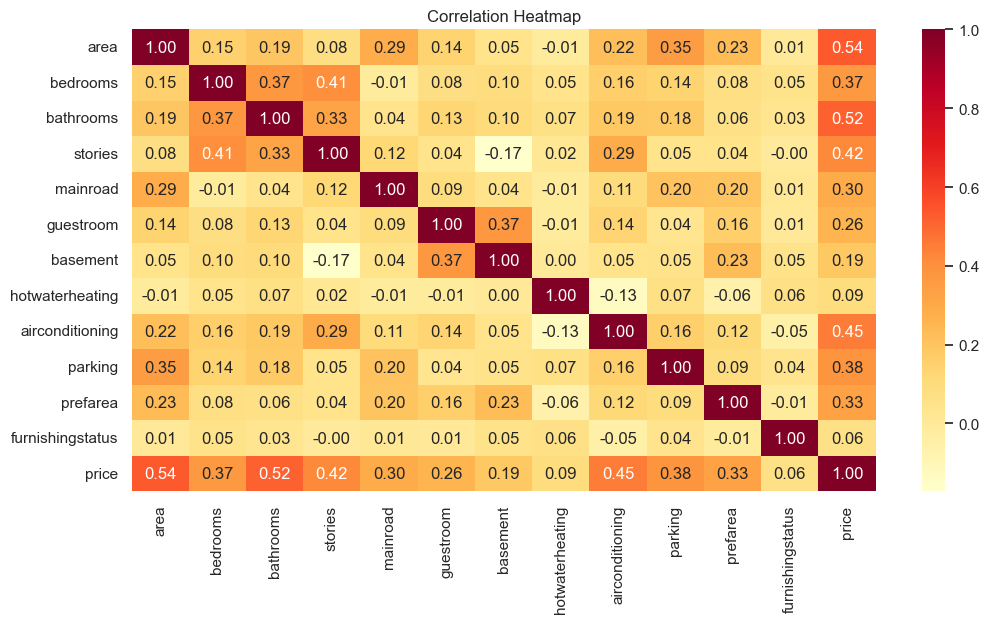

In [106]:
plt.figure(figsize=(12,6))
sns.heatmap(correl.corr(), annot=True, fmt=".2f",cmap='YlOrRd')
plt.title('Correlation Heatmap')
plt.show()

In [81]:
price = pd.DataFrame(df, columns=['price'])
# price = np.log(df['price'])

In [82]:
X_train, X_test, y_train, y_test = train_test_split(df_standardized, price, test_size=0.2, random_state=0)
print("Dimensions of datasets that will be used for training: Input features"
      + str(X_train.shape)
      + ". Output label" + str(y_train.shape))
print("Dimensions of datasets that will be used for testing: Input features"
      + str(X_test.shape)
      + ". Output label"
      + str(y_test.shape))

Dimensions of datasets that will be used for training: Input features(436, 12). Output label(436, 1)
Dimensions of datasets that will be used for testing: Input features(109, 12). Output label(109, 1)


In [83]:
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
model

LinearRegression()

In [84]:
print('Intercept: \n', model.intercept_)
print('Coefficients: \n', model.coef_)

Intercept: 
 [4775510.92141998]
Coefficients: 
 [[553506.02131489 102747.60058575 506609.79136843 382779.85018631
  168952.32805311 170830.84355543 165811.24737145 261140.02827306
  422409.02192422 205636.7941869  300708.13961589  87162.06455258]]


In [ ]:
# Retrieve coefficients
coefficients = model.coef_.flatten()

# Display coefficients with their corresponding feature names
feature_names = df_standardized.columns  # Assumes X_train is a DataFrame with column names
coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})

In [104]:
print(coef_df.sort_values(by='Coefficient', ascending=False))

             Feature    Coefficient
0               area  553506.021315
2          bathrooms  506609.791368
8    airconditioning  422409.021924
3            stories  382779.850186
10          prefarea  300708.139616
7    hotwaterheating  261140.028273
9            parking  205636.794187
5          guestroom  170830.843555
4           mainroad  168952.328053
6           basement  165811.247371
1           bedrooms  102747.600586
11  furnishingstatus   87162.064553


In [85]:
def model_metrics(regressor, y_test, y_pred):
    mse = mean_squared_error(y_test, y_pred)
    print("Root mean squared error: %.2f" % math.sqrt(mse))
    r2 = r2_score(y_test, y_pred)
    print('R2 score: %.2f' % r2)
    return [mse, r2]

metrics = model_metrics(model, y_test, y_pred)

Root mean squared error: 980966.15
R2 score: 0.67


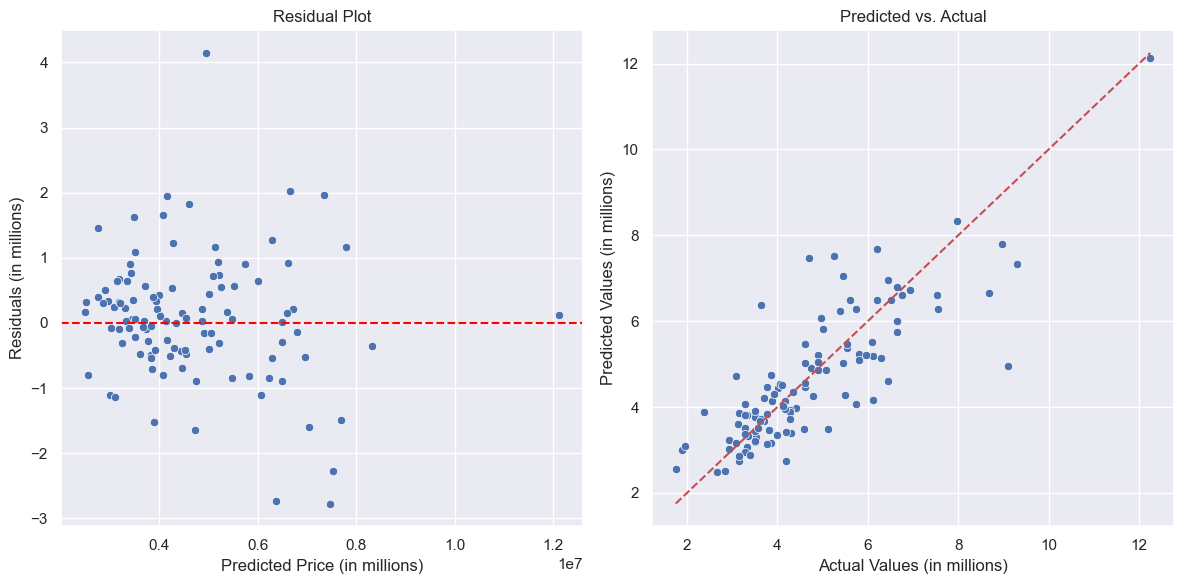

In [108]:
import pandas as pd

# Ensure y_test is a Series by selecting the only column if it's a DataFrame
if isinstance(y_test, pd.DataFrame):
    y_test_series = y_test.iloc[:, 0]  # Select the single column as a Series
else:
    y_test_series = pd.Series(y_test)  # Convert directly if already a Series or array

# Flatten y_pred to ensure it's 1D and convert to Series
y_pred_series = pd.Series(y_pred.flatten())

# Reset index for both to ensure alignment
y_test_series = y_test_series.reset_index(drop=True)
y_pred_series = y_pred_series.reset_index(drop=True)

# Calculate residuals
residuals = y_test_series/1000000 - y_pred_series/1000000

# Plotting
plt.figure(figsize=(12, 6))

# Plot 1: Residuals Plot
plt.subplot(1, 2, 1)
sns.scatterplot(x=y_pred_series, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Price (in millions)')
plt.ylabel('Residuals (in millions)')
plt.title('Residual Plot')

# Plot 2: Predicted vs. Actual
plt.subplot(1, 2, 2)
sns.scatterplot(x=y_test_series/1000000, y=y_pred_series/1000000)
plt.plot([y_test_series.min()/1000000, y_test_series.max()/1000000], [y_test_series.min()/1000000, y_test_series.max()/1000000], 'r--')
plt.xlabel('Actual Values (in millions)')
plt.ylabel('Predicted Values (in millions)')
plt.title('Predicted vs. Actual')

plt.tight_layout()
plt.show()


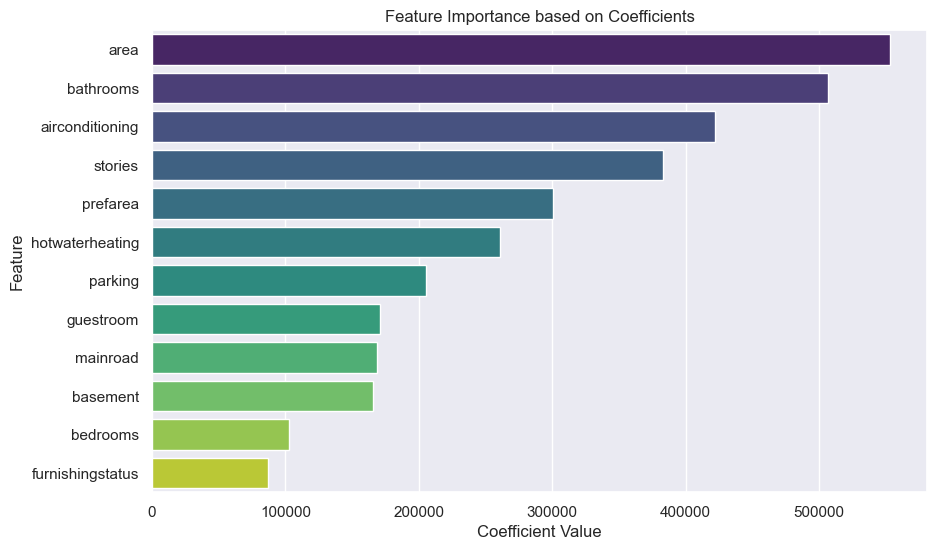

In [109]:
# Sort the coefficients by their absolute value to see the most influential variables
coef_df['Abs_Coefficient'] = coef_df['Coefficient'].abs()
coef_df = coef_df.sort_values(by='Abs_Coefficient', ascending=False)

# Visualize the coefficients
plt.figure(figsize=(10, 6))
sns.barplot(x='Coefficient', y='Feature', data=coef_df, palette='viridis')

plt.title('Feature Importance based on Coefficients')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.show()